# biODYM modelling template

The biODYM modelling template adapts the [ODYM package](https://github.com/IndEcol/ODYM) for performing dynamic MFA in organic waste management. biODYM is capable of:

+ __Dynamic analysis with time-dependent transfer coefficients and input data__
+ __Simultaneous investigation of good and substance level__
+ __Integration of biological processes described with first order models (First order model process FOMP)__
+ __Monte-Carlo-Simulation (MCS)__ 
+ __Export of MFA results to Excel__
+ __Interactive Sankey diagram of MFA results__
 
The extensions are directly written into the notebook and not woven into the ODYM code or provided as separate package. They are practical and working means to explore ODYM’s potential for adaptation, including specific ones (first order model) but also suggestion stimuli for general improvements for coming versions of the framework (interactive Sankey diagrams).The developing process of the biODYM template was based on the ODYM tutorials provided in the GitHub repository of the package.


biODYM includes modelling a case study system which presents the most relevant ODYM functions as well as the added features. The system includes agricultural wheat production, subsequent treatment of residues (wheat straw) and the effect on atmosphere, surface water and aquifer and soil (Figure 1). 

The aim was obtaining information on the impact of the application of agricultural residue treatment products as soil conditioner on the carbon stock of the soil. For the analysis, the system is investigated on good (Biomass) and substance level (Carbon) and is dynamically modelled for the years 2020 until 2040. 
Known input data are biomass and carbon imports from the cultivation, transfer coefficients for all processes (except soil carbon sequestration processes, which are calculated by the added first order model) and standard deviation of all given values. Analysis results are displayed as Sankey diagrams and uncertainty evaluation is performed via Monte-Carlo-Simulation (Number of Monte-Carlo runs (NMC) = 10.000) with log-normal distribution of all input data as approximation standard. The case study input data are arbitrarily chosen and are only meant to demonstrate the templates methodology. 

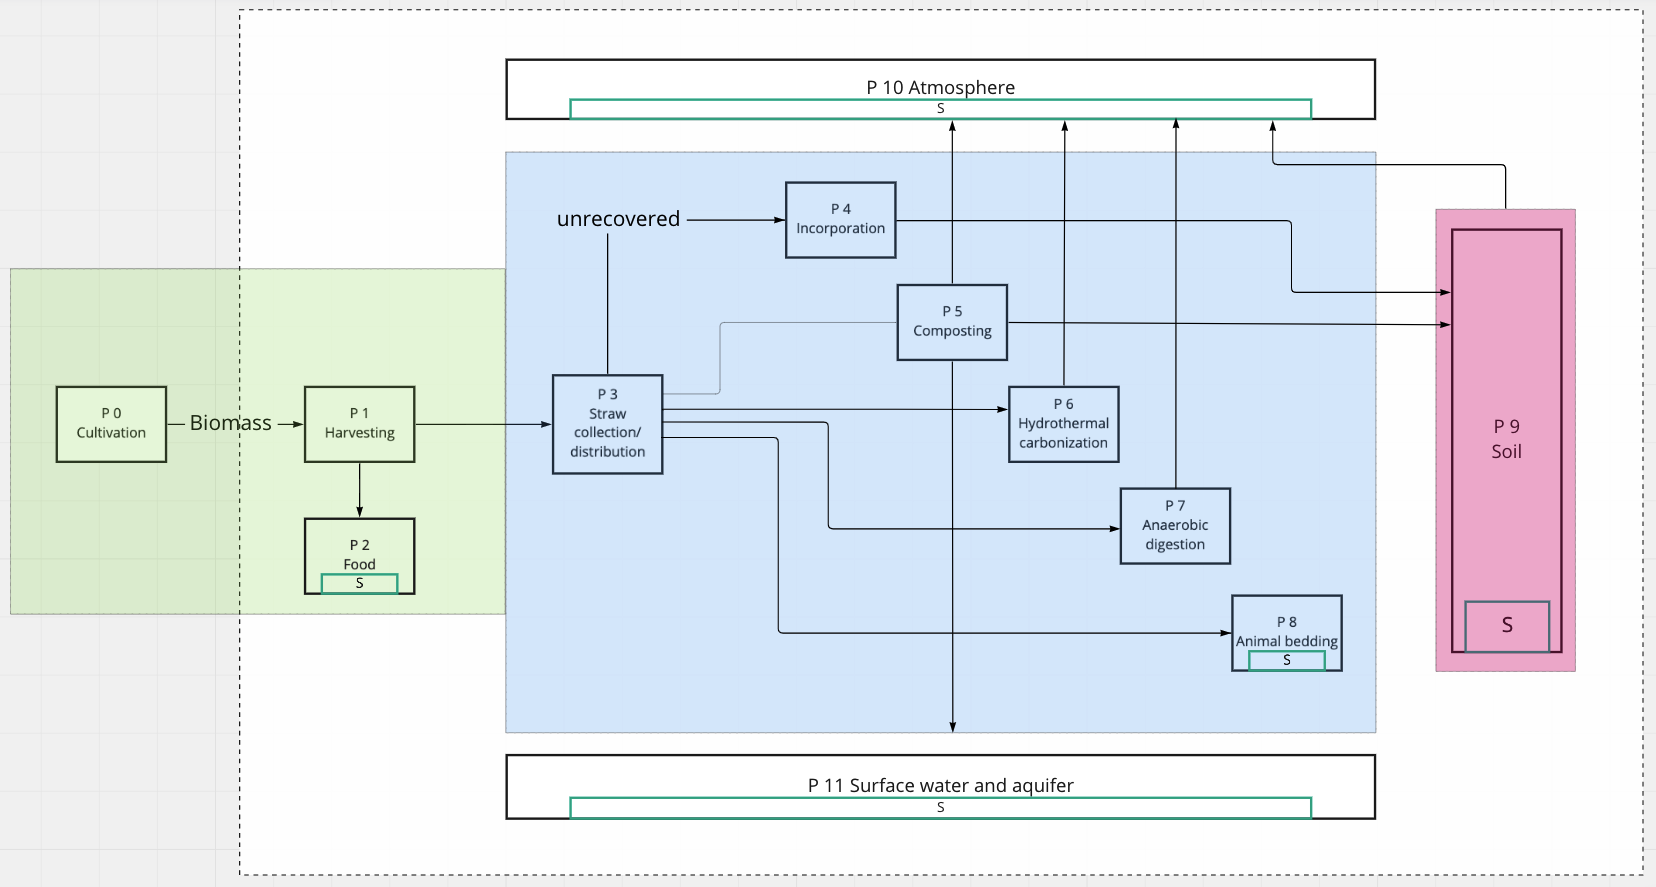
Figure 1: Case study MFA system including agricultural production (green), waste treatment (blue) and sequestration processes of soil conditioner products (red) (done with Miro)


## 0 Load packages

In [53]:
# Load a local copy of the current ODYM branch and required packages:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import pylab

sys.path.insert(0, os.path.join(os.getcwd(),'Framework', 'ODYM master (ver. as of 20.06.22)', 'odym', 'modules')) # add ODYM module directory to system path, absolute
import ODYM_Classes as msc # import the ODYM class file
import ODYM_Functions as msf # import the ODYM function file
import dynamic_stock_model as dsm # import the dynamic stock model library


# Additional packages for plotting
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)


# Additional packages for interactive Sankey diagrams
import plotly.graph_objects as go
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


# Additional packages for data export to excel 
import xlsxwriter


# Additional packages for Monte-Carlo-Simulation (MCS)
from scipy.stats import lognorm


# Enables plotting directly in the notebook (in most cases this function is not needed)
%matplotlib inline

## 1 Definition of system and relevant aspects

In [54]:
ModelClassification  = {} # Create empty dictionary of model classifications

MyYears = list(np.arange(2020,2041)) # Define period of analysis and create list of years
ModelClassification['Time'] = msc.Classification(Name = 'Time', Dimension = 'Time', ID = 1,
                                                 Items = MyYears)
# Classification for time labelled 'Time' must always be present, with Items containing a list of ordered integers representing years, months, or other discrete time intervals


ModelClassification['Element'] = msc.Classification(Name = 'Elements', Dimension = 'Element', 
                                                    ID = 2, Items = ['Biomass', 'C'])
# Classification for elements labelled 'Element' must always be present, with Items containing a list of the symbols of the elements covered.
# Here, other elements (like N or P) could be added to the ODYM MFA system

# Get model time start, end, and duration:
Model_Time_Start = int(min(ModelClassification['Time'].Items))
Model_Time_End   = int(max(ModelClassification['Time'].Items))
Model_Duration   = Model_Time_End - Model_Time_Start


In [55]:
IndexTable = pd.DataFrame({'Aspect'        : ['Time','Element'], # 'Time' and 'Element' must be present!
                           'Description'   : ['Model aspect "time"', 'Model aspect "Element"'],
                           'Dimension'     : ['Time','Element'], # 'Time' and 'Element' are also dimensions
                           'Classification': [ModelClassification[Aspect] for Aspect in ['Time','Element']],
                           'IndexLetter'   : ['t','e']}) # Unique one letter (upper or lower case) indices to be used later for calculations.

IndexTable.set_index('Aspect', inplace = True) # Default indexing of IndexTable, other indices are produced on the fly

IndexTable

,Description,Dimension,Classification,IndexLetter
Aspect,,,,
Time,"Model aspect ""time""",Time,<ODYM_Classes.Classification object at 0x7f842...,t
Element,"Model aspect ""Element""",Element,<ODYM_Classes.Classification object at 0x7f842...,e


In [56]:
# Initialize MFA system
Dyn_MFA_System = msc.MFAsystem(Name = 'TestSystem', 
                      Geogr_Scope = 'TestRegion', 
                      Unit = 't', 
                      ProcessList = [], 
                      FlowDict = {}, 
                      StockDict = {},
                      ParameterDict = {}, 
                      Time_Start = Model_Time_Start, 
                      Time_End = Model_Time_End, 
                      IndexTable = IndexTable, 
                      Elements = IndexTable.loc['Element'].Classification.Items) 

In [57]:
# Define all processes and specify an ID (ID is used to assign flows and stocks to processes)
Dyn_MFA_System.ProcessList = [] 
Dyn_MFA_System.ProcessList.append(msc.Process(Name = 'Cultivation' , ID   = 0))
Dyn_MFA_System.ProcessList.append(msc.Process(Name = 'Harvesting'    , ID   = 1))
Dyn_MFA_System.ProcessList.append(msc.Process(Name = 'Food'    , ID   = 2))
Dyn_MFA_System.ProcessList.append(msc.Process(Name = 'Straw c&d'  , ID   = 3))
Dyn_MFA_System.ProcessList.append(msc.Process(Name = 'Incorporation'   , ID   = 4))
Dyn_MFA_System.ProcessList.append(msc.Process(Name = 'Composting'   , ID   = 5))
Dyn_MFA_System.ProcessList.append(msc.Process(Name = 'HTC'  , ID   = 6))
Dyn_MFA_System.ProcessList.append(msc.Process(Name = 'AD'  , ID   = 7))
Dyn_MFA_System.ProcessList.append(msc.Process(Name = 'Animal bedding'  , ID   = 8))
Dyn_MFA_System.ProcessList.append(msc.Process(Name = 'Soil'  , ID   = 9))
Dyn_MFA_System.ProcessList.append(msc.Process(Name = 'Atmosphere'  , ID   = 10))
Dyn_MFA_System.ProcessList.append(msc.Process(Name = 'Surface water and aquifer'  , ID   = 11))


In [58]:
# FlowDict is part of the ODYM data base 
# Define the flows of the system
# Parameters have the following attributes:
    # Name: Choose name
    # P_Start: Which process initiates the flow
    # P_End: Target process
    # Indices: The flows in this case depend on time and the element investigated
    # Values: Values get assigned later, that is why in the cell the are specified as "None"
    # Uncert: Only F_0_1 has defined uncertainty. The uncertainty of other the other flows are determined by MCS

Dyn_MFA_System.FlowDict['F_0_1'] = msc.Flow(Name = 'F_0_1', P_Start = 0, P_End = 1,
                                            Indices = 't,e', Values=None, Uncert = np.zeros(shape = (len(MyYears),len(ModelClassification['Element'].Items))))
Dyn_MFA_System.FlowDict['F_1_2'] = msc.Flow(Name = 'F_1_2', P_Start = 1, P_End = 2,
                                            Indices = 't,e', Values=None)
Dyn_MFA_System.FlowDict['F_1_3'] = msc.Flow(Name = 'F_1_3', P_Start = 1, P_End = 3,
                                            Indices = 't,e', Values=None)
Dyn_MFA_System.FlowDict['F_3_4'] = msc.Flow(Name = 'F_3_4', P_Start = 3, P_End = 4,
                                            Indices = 't,e', Values=None)
Dyn_MFA_System.FlowDict['F_3_5'] = msc.Flow(Name = 'F_3_5', P_Start = 3, P_End = 5,
                                            Indices = 't,e', Values=None)
Dyn_MFA_System.FlowDict['F_3_6'] = msc.Flow(Name = 'F_3_6', P_Start = 3, P_End = 6,
                                            Indices = 't,e', Values=None)
Dyn_MFA_System.FlowDict['F_3_7'] = msc.Flow(Name = 'F_3_7', P_Start = 3, P_End = 7,
                                            Indices = 't,e', Values=None)
Dyn_MFA_System.FlowDict['F_3_8'] = msc.Flow(Name = 'F_3_8', P_Start = 3, P_End = 8,
                                            Indices = 't,e', Values=None)
Dyn_MFA_System.FlowDict['F_4_9'] = msc.Flow(Name = 'F_4_9', P_Start = 4, P_End = 9,
                                            Indices = 't,e', Values=None)
Dyn_MFA_System.FlowDict['F_5_9'] = msc.Flow(Name = 'F_5_9', P_Start = 5, P_End = 9,
                                            Indices = 't,e', Values=None)
Dyn_MFA_System.FlowDict['F_5_10'] = msc.Flow(Name = 'F_5_10', P_Start = 5, P_End = 10,
                                            Indices = 't,e', Values=None)
Dyn_MFA_System.FlowDict['F_5_11'] = msc.Flow(Name = 'F_5_11', P_Start = 5, P_End = 11,
                                            Indices = 't,e', Values=None)
Dyn_MFA_System.FlowDict['F_6_10'] = msc.Flow(Name = 'F_6_10', P_Start = 6, P_End = 10,
                                            Indices = 't,e', Values=None)
Dyn_MFA_System.FlowDict['F_7_10'] = msc.Flow(Name = 'F_7_10', P_Start = 7, P_End = 10,
                                            Indices = 't,e', Values=None)
Dyn_MFA_System.FlowDict['F_9_10'] = msc.Flow(Name = 'F_9_10', P_Start = 9, P_End = 10,
                                            Indices = 't,e', Values=None)



# StockDict is part of the ODYM data base 
# Define the stocks of the system
# Parameters have the following attributes:
    # Name: Choose name
    # P_Res: Which process includes the stock
    # Type: 0 for stock and 1 for stock change
    # Indices: The flows in this case depend on time and the element investigated
    # Values: Values get assigned later, that is why in the cell the are specified as "None"
    
    
Dyn_MFA_System.StockDict['dS_2']  = msc.Stock(Name = 'dS_2', P_Res = 2, Type = 1,
                                              Indices = 't,e', Values=None)
Dyn_MFA_System.StockDict['S_2']   = msc.Stock(Name = 'S_2', P_Res = 2, Type = 0,
                                              Indices = 't,e', Values=None)


Dyn_MFA_System.StockDict['dS_8']  = msc.Stock(Name = 'dS_8', P_Res = 8, Type = 1,
                                              Indices = 't,e', Values=None)
Dyn_MFA_System.StockDict['S_8']   = msc.Stock(Name = 'S_8', P_Res = 8, Type = 0,
                                              Indices = 't,e', Values=None)

Dyn_MFA_System.StockDict['dS_9']  = msc.Stock(Name = 'dS_9', P_Res = 9, Type = 1,
                                              Indices = 't,e', Values=None)
Dyn_MFA_System.StockDict['S_9']   = msc.Stock(Name = 'S_9', P_Res = 9, Type = 0,
                                              Indices = 't,e', Values=None)

Dyn_MFA_System.StockDict['dS_10']  = msc.Stock(Name = 'dS_10', P_Res = 10, Type = 1,
                                              Indices = 't,e', Values=None)
Dyn_MFA_System.StockDict['S_10']   = msc.Stock(Name = 'S_10', P_Res = 10, Type = 0,
                                              Indices = 't,e', Values=None)

Dyn_MFA_System.StockDict['dS_11']  = msc.Stock(Name = 'dS_11', P_Res = 11, Type = 1,
                                              Indices = 't,e', Values=None)
Dyn_MFA_System.StockDict['S_11']   = msc.Stock(Name = 'S_11', P_Res = 11, Type = 0,
                                              Indices = 't,e', Values=None)


# Assign empty arrays to flows according to dimensions
Dyn_MFA_System.Initialize_FlowValues() 
Dyn_MFA_System.Initialize_StockValues() 

## 2 Data input into model

In [59]:
# Import input data from Excel sheet (further elements could be added here)
# Flows, transfer coefficients and relative Standard Deviation values

# Biomass

path = os.path.join(os.getcwd(), 'biODYM_input_data_template.xlsx')


df_f_B_total = pd.read_excel (path, sheet_name='Flow_data_Biomass')
df_f_B = df_f_B_total[[k for i, k in enumerate(df_f_B_total.columns, 1) if i % 2 == 0 and i>1]]
df_f_B_relSTD = df_f_B_total[[k for i, k in enumerate(df_f_B_total.columns, 1) if i % 2 != 0 and i >1]]

F_B_Dict = df_f_B.to_dict('list')
F_B_Dict_relSTD = df_f_B_relSTD.to_dict('list')


df_TC_B_total = pd.read_excel (path, sheet_name='TC_data_Biomass').iloc[:, 1:30]
df_TC_B = df_TC_B_total[[k for i, k in enumerate(df_TC_B_total.columns, 1) if i % 2 != 0]]

df_TC_B_relSTD = df_TC_B_total[[k for i, k in enumerate(df_TC_B_total.columns, 1) if i % 2 == 0]]
 

TC_B_Dict = df_TC_B.to_dict('list')
TC_B_Dict_relSTD = df_TC_B_relSTD.to_dict('list')


# Put input flow data into applicable form
InflowArray_B = np.zeros(len(MyYears))
for m in range(0,21):
    YearPosition               = MyYears.index(int(df_f_B_total.iat[m,0]))
    InflowArray_B[YearPosition] = df_f_B_total.iat[m,1]  

In [60]:
# Import input data from Excel sheet
# Flows, transfer coefficients and relative Standard Deviation values

# Carbon

df_f_C_total = pd.read_excel (path, sheet_name='Flow_data_Carbon')
df_f_C = df_f_C_total[[k for i, k in enumerate(df_f_C_total.columns, 1) if i % 2 == 0 and i>1]]
df_f_C_relSTD = df_f_C_total[[k for i, k in enumerate(df_f_C_total.columns, 1) if i % 2 != 0 and i >1]]

F_C_Dict = df_f_C.to_dict('list')
F_C_Dict_relSTD = df_f_C_relSTD.to_dict('list')


df_TC_C_total = pd.read_excel (path, sheet_name='TC_data_Carbon').iloc[:, 1:30]
df_TC_C = df_TC_C_total[[k for i, k in enumerate(df_TC_C_total.columns, 1) if i % 2 != 0]]

df_TC_C_relSTD = df_TC_C_total[[k for i, k in enumerate(df_TC_C_total.columns, 1) if i % 2 == 0]]
 

TC_C_Dict = df_TC_C.to_dict('list')
TC_C_Dict_relSTD = df_TC_C_relSTD.to_dict('list')


# Put input flow data into applicable form
InflowArray_C = np.zeros(len(MyYears))
for m in range(0,21):
    YearPosition               = MyYears.index(int(df_f_C_total.iat[m,0]))
    InflowArray_C[YearPosition] = df_f_C_total.iat[m,1]  

In [61]:
# ParameterDict is part of the ODYM data base 
# It stores the imported Excel data in a form that can be used for later calculations
# Parameters have the following attributes:
    # Name: Choose name
    # ID: Number parameters
    # P_res: Assign parameter to process (e.g. TC_1_2 belongs to process 1)
    # MetaData: Can be left like this
    # Indices: The parameters in this case depend on time and the element investigated
    # Values: Values get assigned later, that is why in the cell the are specified as "None"
    # Uncert: All input data is occupied with uncertainty depending on time and element. Here, an empty created fitting the dimesions.
    # Units: Choose unit
    
ParameterDict = {}

Uncert_array = np.zeros(shape = (len(MyYears),len(ModelClassification['Element'].Items)))

ParameterDict['F_0_1']  = msc.Parameter(Name = 'F_0_1', ID = 1, P_Res = 1,
                                        MetaData = None, Indices = 't,e',
                                        Values = None, Uncert = Uncert_array, Unit = 't/yr')


ParameterDict['TC_1_2'] = msc.Parameter(Name = 'TC_1_2',  ID = 2, P_Res = 1,
                                         MetaData = None, Indices = 't,e',
                                         Values = None, Uncert= Uncert_array, Unit = '1')
ParameterDict['TC_1_3'] = msc.Parameter(Name = 'TC_1_3', ID = 3, P_Res = 1,
                                         MetaData = None, Indices = 't,e', 
                                         Values = None, Uncert= Uncert_array, Unit = '1')
ParameterDict['TC_3_4'] = msc.Parameter(Name = 'TC_3_4',  ID = 4, P_Res = 3,
                                         MetaData = None, Indices = 't,e', 
                                         Values = None, Uncert= Uncert_array, Unit = '1')
ParameterDict['TC_3_5'] = msc.Parameter(Name = 'TC_3_5',  ID = 5, P_Res = 3,
                                         MetaData = None, Indices = 't,e', 
                                         Values = None, Uncert= Uncert_array, Unit = '1')
ParameterDict['TC_3_6'] = msc.Parameter(Name = 'TC_3_6',  ID = 6, P_Res = 3,
                                         MetaData = None, Indices = 't,e', 
                                         Values = None, Uncert= Uncert_array, Unit = '1')
ParameterDict['TC_3_7'] = msc.Parameter(Name = 'TC_3_7',  ID = 7, P_Res = 3,
                                         MetaData = None, Indices = 't,e', 
                                         Values = None, Uncert= Uncert_array, Unit = '1')
ParameterDict['TC_3_8'] = msc.Parameter(Name = 'TC_3_8',  ID = 8, P_Res = 3,
                                         MetaData = None, Indices = 't,e', 
                                         Values = None, Uncert= Uncert_array, Unit = '1')
ParameterDict['TC_4_9'] = msc.Parameter(Name = 'TC_4_9',  ID = 9, P_Res = 4,
                                         MetaData = None, Indices = 't,e', 
                                         Values = None, Uncert= Uncert_array, Unit = '1')
ParameterDict['TC_5_9'] = msc.Parameter(Name = 'TC_5_9',  ID = 10, P_Res = 5,
                                         MetaData = None, Indices = 't,e', 
                                         Values = None, Uncert= Uncert_array, Unit = '1')
ParameterDict['TC_5_10'] = msc.Parameter(Name = 'TC_5_10',  ID = 10, P_Res = 5,
                                         MetaData = None, Indices = 't,e', 
                                         Values = None, Uncert= Uncert_array, Unit = '1')
ParameterDict['TC_5_11'] = msc.Parameter(Name = 'TC_5_11',  ID = 11, P_Res = 5,
                                         MetaData = None, Indices = 't,e', 
                                         Values = None, Uncert= Uncert_array, Unit = '1')
ParameterDict['TC_6_10'] = msc.Parameter(Name = 'TC_6_10',  ID = 12, P_Res = 6,
                                         MetaData = None, Indices = 't,e', 
                                         Values = None, Uncert= Uncert_array, Unit = '1')
ParameterDict['TC_7_10'] = msc.Parameter(Name = 'TC_7_10',  ID = 13, P_Res = 7,
                                         MetaData = None, Indices = 't,e', 
                                         Values = None, Uncert= Uncert_array, Unit = '1')


# Assign parameter dictionary to MFA system:
Dyn_MFA_System.ParameterDict = ParameterDict

# Assign empty arrays to parameters according to dimensions, analogous to the procedure in FlowDict and StockDict
Dyn_MFA_System.Initialize_ParameterValues()

In [62]:
# Add all input data to ParametersDict
# Parameters, Flows and stocks have the shape (number of years, number of elements)
# ParameterDict['F_0_1'].Values[:,0] addresses all years for the first element, that is Biomass
# ParameterDict['F_0_1'].Values[:,1] addresses all years for the second element, that is Carbon
# ParameterDict['F_0_1'].Values[:,2] would address all years for the third element, e.g. Nitrogen

ParameterDict['F_0_1'].Values[:,0] = InflowArray_B 
ParameterDict['F_0_1'].Values[:,1] = InflowArray_C
ParameterDict['F_0_1'].Uncert[:,0] = F_B_Dict_relSTD['F_0_1_relSTD']
ParameterDict['F_0_1'].Uncert[:,1] = F_C_Dict_relSTD['F_0_1_relSTD']

for element in ParameterDict:
    if element != 'F_0_1':
        ParameterDict[element].Values[:,0] = TC_B_Dict[element]
        ParameterDict[element].Values[:,1] = TC_C_Dict[element]
        ParameterDict[element].Uncert[:,0] = TC_B_Dict_relSTD[f"{element}_relSTD"]
        ParameterDict[element].Uncert[:,1] = TC_C_Dict_relSTD[f"{element}_relSTD"]

In [63]:
# Check whether flow value arrays match their indices, etc. See ODYM method documentation.
Dyn_MFA_System.Consistency_Check() 

(True, True, True)

## 3 MFA Calculations

### 3.1 Solution MFA

### 3.1.1 Solution MFA pt. I (w/o FOMP)

In [64]:
# The data of the ParameterDict is used to calculate flows and stocks of the system
# All flows and stocks that do not depend on first order model processes (FOMP) are calculated here
# Values and uncertainty for F_0_1 are known
# Other flows get calculated by: F_y_z = F_x_y * TC_y_z (other calculations can be used, depending on input data)
# Stock changes correspond to the difference of inflow to outflow
# Stocks are cumulated stock changes


Dyn_MFA_System.FlowDict['F_0_1'].Values = Dyn_MFA_System.ParameterDict['F_0_1'].Values

Dyn_MFA_System.FlowDict['F_0_1'].Uncert = Dyn_MFA_System.ParameterDict['F_0_1'].Uncert


Dyn_MFA_System.FlowDict['F_1_2'].Values = Dyn_MFA_System.FlowDict['F_0_1'].Values*Dyn_MFA_System.ParameterDict['TC_1_2'].Values

Dyn_MFA_System.FlowDict['F_1_3'].Values = Dyn_MFA_System.FlowDict['F_0_1'].Values*Dyn_MFA_System.ParameterDict['TC_1_3'].Values

Dyn_MFA_System.FlowDict['F_3_4'].Values = Dyn_MFA_System.FlowDict['F_1_3'].Values*Dyn_MFA_System.ParameterDict['TC_3_4'].Values

Dyn_MFA_System.FlowDict['F_3_5'].Values = Dyn_MFA_System.FlowDict['F_1_3'].Values*Dyn_MFA_System.ParameterDict['TC_3_5'].Values

Dyn_MFA_System.FlowDict['F_3_6'].Values = Dyn_MFA_System.FlowDict['F_1_3'].Values*Dyn_MFA_System.ParameterDict['TC_3_6'].Values

Dyn_MFA_System.FlowDict['F_3_7'].Values = Dyn_MFA_System.FlowDict['F_1_3'].Values*Dyn_MFA_System.ParameterDict['TC_3_7'].Values

Dyn_MFA_System.FlowDict['F_3_8'].Values = Dyn_MFA_System.FlowDict['F_1_3'].Values*Dyn_MFA_System.ParameterDict['TC_3_8'].Values

Dyn_MFA_System.FlowDict['F_4_9'].Values = Dyn_MFA_System.FlowDict['F_3_4'].Values*Dyn_MFA_System.ParameterDict['TC_4_9'].Values

Dyn_MFA_System.FlowDict['F_5_9'].Values = Dyn_MFA_System.FlowDict['F_3_5'].Values*Dyn_MFA_System.ParameterDict['TC_5_9'].Values

Dyn_MFA_System.FlowDict['F_5_10'].Values = Dyn_MFA_System.FlowDict['F_3_5'].Values*Dyn_MFA_System.ParameterDict['TC_5_10'].Values

Dyn_MFA_System.FlowDict['F_5_11'].Values = Dyn_MFA_System.FlowDict['F_3_5'].Values*Dyn_MFA_System.ParameterDict['TC_5_11'].Values

Dyn_MFA_System.FlowDict['F_6_10'].Values = Dyn_MFA_System.FlowDict['F_3_6'].Values*Dyn_MFA_System.ParameterDict['TC_6_10'].Values

Dyn_MFA_System.FlowDict['F_7_10'].Values = Dyn_MFA_System.FlowDict['F_3_7'].Values*Dyn_MFA_System.ParameterDict['TC_7_10'].Values



Dyn_MFA_System.StockDict['dS_2'].Values = Dyn_MFA_System.FlowDict['F_1_2'].Values

Dyn_MFA_System.StockDict['dS_8'].Values = Dyn_MFA_System.FlowDict['F_3_8'].Values


Dyn_MFA_System.StockDict['S_2'].Values = Dyn_MFA_System.StockDict['dS_2'].Values.cumsum(axis = 0)

Dyn_MFA_System.StockDict['S_8'].Values = Dyn_MFA_System.StockDict['dS_8'].Values.cumsum(axis = 0)


BioInflowArray = Dyn_MFA_System.FlowDict['F_4_9'].Values + Dyn_MFA_System.FlowDict['F_5_9'].Values

### 3.1.2 First order model processes (FOMP)

The carbon sequestration processes in the soil are calculated with a first order decay model according to [Cayuela et al., 2010](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1757-1707.2010.01055.x)  based on [Robertson & Paul, 2000](https://link.springer.com/chapter/10.1007/978-1-4612-1224-9_8): 

$$ C_{remaining} (t)=f \cdot exp⁡(-k_{1} \cdot t)+(100-f) \cdot exp⁡(-k_{2} \cdot t) $$

To keep calculations simple, it is assumed that this is the only equation that leads to outflows of the process, the remaining fractions of biomass accumulate as stock without any emissions.

Instead of extensive looping, array calculation has been used to obtain results. Less intuitive to understand but much faster, which is quite relevant for the later MCS.

In [65]:
# Define BioParameter class to create BioParameterDict analogously to the ParameterDict of ODYM 
# Code and comments copied from ODYM_Classes.py

class Obj(object):
    """
    Class with the object definition for a data object (system, process, flow, ...) in ODYM
    """
    def __init__(self, Name=None, ID=None, UUID=None):
        """ Basic initialisation of Obj."""
        self.Name            = Name # object name
        self.ID              = ID   # object ID
        self.UUID            = UUID # object UUID
        self.Aspects         = {'Time': 'Model time','Cohort': 'Age-cohort','OriginProcess':'Process where flow originates','DestinationProcess':'Destination process of flow','OriginRegion': 'Region where flow originates from','DestinationRegion': 'Region where flow is bound to', 'Good': 'Process, good, or commodity', 'Material': 'Material: ore, alloy, scrap type, ...','Element': 'Chemical element' } # Define the aspects of the system variables
        self.Dimensions      = {'Time': 'Time', 'Process':'Process', 'Region': 'Region', 'Good': 'Process, good, or commodity', 'Material': 'Material: ore, alloy, scrap type, ...','Element': 'Chemical element' } # Define the dimensions of the system variables


class BioParameter(Obj):
  
    """
    Class with the definition and methods for biological process parameters
    """
    
    def __init__(self, Name = None, ID = None, UUID = None, P_Res = None, MetaData = None, Indices = None, Values=None, Uncert=None, Unit = None):
        """ Basic initialisation of a parameter."""
        Obj.__init__(self, Name = Name, ID = ID, UUID = UUID) # Hand over parameters to parent class init
        self.P_Res       = P_Res   # id of process to which parameter is assigned (id: int)
        self.Indices     = Indices # String with indices as defined in IndexTable, separated by ,: 't,c,p,s,e'
        self.MetaData    = MetaData # Dictionary with additional metadata
        self.Values      = Values   # parameter values, np.array, multidimensional, unit is Unit
        self.Uncert      = Uncert  # uncertainty of value in %
        self.Unit        = Unit   # Unit of parameter values

In [66]:
# Define parameters for the biological process and their uncertainty
# Values according to [Cayuela et al., 2010]

BioParameterDict = {}

BioParameterDict['f'] = BioParameter(Name = 'f', ID = 1, P_Res = 9,
                                        MetaData = None, Indices = None,
                                        Values = 0.048, Uncert = 0.05, Unit = '1')

BioParameterDict['k1'] = BioParameter(Name = 'k1', ID = 1, P_Res = 9,
                                        MetaData = None, Indices = None,
                                        Values = 72.0875, Uncert = 0.05, Unit = '1/a')

BioParameterDict['k2'] = BioParameter(Name = 'k2', ID = 1, P_Res = 9,
                                        MetaData = None, Indices = None,
                                        Values = 0.9855, Uncert = 0.05, Unit = '1/a')

In [67]:
# The above-mentioned equation is combined with inflow values for each year in one big array

MyYears_array = np.array(list(range(0, len(MyYears))))
relative_decay = (BioParameterDict['f'].Values * (np.exp(-BioParameterDict['k1'].Values * MyYears_array))+(1-BioParameterDict['f'].Values) * np.exp(-BioParameterDict['k2'].Values * MyYears_array))
# relative_decay implements the equation


d = np.diag(BioInflowArray[:,1])
d = np.tril(np.ones((len(MyYears))))
d = d*BioInflowArray[:,1]

for column in range(len(MyYears)):
    d[:,column] = d[:,column]*np.roll(relative_decay, column, axis= 0)
d_sum = np.sum(d, axis= 1)


S = d_sum

dS = d_sum.copy()
dS[1:] -= dS[:-1]


### 3.1.3 Solution MFA pt. II (w/ FOMP)

In [69]:
# Add first order model results to ODYM data structure

# Carbon sequestration is the only process that leads to output, rest gets stored
Dyn_MFA_System.FlowDict['F_9_10'].Values[:,1] = BioInflowArray[:,1] - dS
Dyn_MFA_System.FlowDict['F_9_10'].Values[:,0] = BioInflowArray[:,1] - dS


Dyn_MFA_System.StockDict['dS_9'].Values = Dyn_MFA_System.FlowDict['F_4_9'].Values + Dyn_MFA_System.FlowDict['F_5_9'].Values - Dyn_MFA_System.FlowDict['F_9_10'].Values
Dyn_MFA_System.StockDict['S_9'].Values = Dyn_MFA_System.StockDict['dS_9'].Values.cumsum(axis = 0)


Dyn_MFA_System.StockDict['dS_10'].Values = Dyn_MFA_System.FlowDict['F_5_10'].Values + Dyn_MFA_System.FlowDict['F_6_10'].Values + Dyn_MFA_System.FlowDict['F_7_10'].Values + Dyn_MFA_System.FlowDict['F_9_10'].Values
Dyn_MFA_System.StockDict['S_10'].Values = Dyn_MFA_System.StockDict['dS_10'].Values.cumsum(axis = 0)


Dyn_MFA_System.StockDict['dS_11'].Values = Dyn_MFA_System.FlowDict['F_5_11'].Values
Dyn_MFA_System.StockDict['S_11'].Values = Dyn_MFA_System.StockDict['dS_11'].Values.cumsum(axis = 0)

### 3.1.4 Final Mass balance check

In [70]:
Bal = Dyn_MFA_System.MassBalance()
print(Bal.shape) # dimensions of balance are: time step x process x element
print(np.abs(Bal).sum(axis = 0).sum(axis = 1)) # reports the sum of all absolute balancing errors by process.

(21, 12, 2)
[3.24185123e-13 0.00000000e+00 0.00000000e+00 2.67119660e-13
 0.00000000e+00 2.08166817e-14 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]


### 3.2 Monte-Carlo-Simulation

In [72]:
# Monte-Carlo-Simulation is performed with 10.000 model runs and consideration of all uncertainties of input data
# Log-normal distribution for all input data is assumed

NMC = 10000 # Number of MC model runs
MC_ParameterDict   = {} 
# Creating a new ParameterDict, that extends the ODYM ParameterDict
# Each value has now dimensions (NMC, number of years, number of elements)

# Generate random values
for parameter in Dyn_MFA_System.ParameterDict:
    Mean = Dyn_MFA_System.ParameterDict[parameter].Values[:] 
    SD = Dyn_MFA_System.ParameterDict[parameter].Values[:]*Dyn_MFA_System.ParameterDict[parameter].Uncert[:]
    s = np.sqrt(np.log(1+SD**2/Mean**2)) # Convert SD and Mean to s
    mu = np.log(Mean)-0.5*(s**1) # Convert SD and Mean to mu
    Array_MC_parameter = np.zeros((NMC,len(MyYears), len(ModelClassification['Element'].Items)))
    for a in range(0,len(ModelClassification['Element'].Items)):
        for b in range(0, len(MyYears)):
            r = lognorm.rvs(s[b,a], scale = np.exp(mu[b,a]), size = NMC) # Generate random values
            Array_MC_parameter[:,b,a] = r
        MC_ParameterDict[Dyn_MFA_System.ParameterDict[parameter].Name] = Array_MC_parameter #Create dictionary entry

In [73]:
# Repeat calculations with the new extended dictionaries
# Copy calculations, paste them here and change dictionaries with "find and replace"

MC_FlowDict = {}
MC_StockDict = {}

MC_FlowDict['F_0_1'] = MC_ParameterDict['F_0_1']


MC_FlowDict['F_1_2'] = MC_FlowDict['F_0_1']*MC_ParameterDict['TC_1_2']

MC_FlowDict['F_1_3'] = MC_FlowDict['F_0_1']*MC_ParameterDict['TC_1_3']

MC_FlowDict['F_3_4'] = MC_FlowDict['F_1_3']*MC_ParameterDict['TC_3_4']

MC_FlowDict['F_3_5'] = MC_FlowDict['F_1_3']*MC_ParameterDict['TC_3_5']

MC_FlowDict['F_3_6'] = MC_FlowDict['F_1_3']*MC_ParameterDict['TC_3_6']

MC_FlowDict['F_3_7'] = MC_FlowDict['F_1_3']*MC_ParameterDict['TC_3_7']

MC_FlowDict['F_3_8'] = MC_FlowDict['F_1_3']*MC_ParameterDict['TC_3_8']

MC_FlowDict['F_4_9'] = MC_FlowDict['F_3_4']*MC_ParameterDict['TC_4_9']

MC_FlowDict['F_5_9'] = MC_FlowDict['F_3_5']*MC_ParameterDict['TC_5_9']

MC_FlowDict['F_5_10'] = MC_FlowDict['F_3_5']*MC_ParameterDict['TC_5_10']

MC_FlowDict['F_5_11'] = MC_FlowDict['F_3_5']*MC_ParameterDict['TC_5_11']

MC_FlowDict['F_6_10'] = MC_FlowDict['F_3_6']*MC_ParameterDict['TC_6_10']

MC_FlowDict['F_7_10'] = MC_FlowDict['F_3_7']*MC_ParameterDict['TC_7_10']



MC_StockDict['dS_2'] = MC_FlowDict['F_1_2']

MC_StockDict['S_2'] = MC_StockDict['dS_2'].cumsum(axis = 1)

MC_StockDict['dS_8'] = MC_FlowDict['F_3_8']

MC_StockDict['S_8'] = MC_StockDict['dS_8'].cumsum(axis = 1)



MC_BioInflowArray = MC_FlowDict['F_4_9'] + MC_FlowDict['F_5_9']


In [74]:
# Same procedure for FOMP


MC_BioParameterDict   = {}

for bio_parameter in BioParameterDict:
    Array_MC_bio_parameter = np.zeros(NMC)
    Mean = BioParameterDict[bio_parameter].Values
    SD = BioParameterDict[bio_parameter].Values*BioParameterDict[bio_parameter].Uncert
    s = np.sqrt(np.log(1+SD**2/Mean**2))
    mu = np.log(Mean)-0.5*(s**1)
    r = lognorm.rvs(s, scale = np.exp(mu), size = NMC)
    Array_MC_bio_parameter = r 
    MC_BioParameterDict[bio_parameter] = Array_MC_bio_parameter

In [75]:
# Repeat calculations with the MC data
# NMC dimension has to be considered

MC_relative_decay = (MC_BioParameterDict['f'].reshape(NMC,1) * (np.exp(-MC_BioParameterDict['k1'].reshape(NMC,1) * MyYears_array))+(1-MC_BioParameterDict['f'].reshape(NMC,1)) * np.exp(-MC_BioParameterDict['k2'].reshape(NMC,1) * MyYears_array))
MC_bioparameter_S = np.zeros((NMC,len(MyYears), len(ModelClassification['Element'].Items)))
MC_bioparameter_dS = np.zeros((NMC,len(MyYears), len(ModelClassification['Element'].Items)))

for i in range(0, NMC):
    d = np.diag(MC_BioInflowArray[i,:,1])
    d = np.tril(np.ones((len(MyYears))))
    d = d*MC_BioInflowArray[i,:,1]
    d.shape
    for column in range(len(MyYears)):
            d[:,column] = d[:,column]*np.roll(MC_relative_decay[i], column, axis=0)
    d.shape
    d_sum = np.sum(d, axis = 1)
    MC_bioparameter_S[i,:,1] = d_sum
    dS = d_sum.copy()
    dS[1:] -= dS[:-1]
    MC_bioparameter_dS[i,:,0] = dS
    MC_bioparameter_dS[i,:,1] = dS

In [76]:
# Repeat calculations with the MC data
# For F_9_10, the NMC dimension has to be taken into account, that is why [:,:,1] is used and not [:,1]
# also axis has to be changed from 0 to 1

MC_FlowDict['F_9_10'] = np.zeros((NMC,len(MyYears),len(ModelClassification['Element'].Items)))
MC_FlowDict['F_9_10'][:,:,1] = MC_BioInflowArray[:,:,1] - MC_bioparameter_dS[:,:,1]
MC_FlowDict['F_9_10'][:,:,0] = MC_BioInflowArray[:,:,1] - MC_bioparameter_dS[:,:,1]


MC_StockDict['dS_9'] = MC_FlowDict['F_4_9'] + MC_FlowDict['F_5_9'] - MC_FlowDict['F_9_10']
MC_StockDict['S_9'] = MC_StockDict['dS_9'].cumsum(axis = 1)


MC_StockDict['dS_10'] = MC_FlowDict['F_5_10'] + MC_FlowDict['F_6_10'] + MC_FlowDict['F_7_10'] + MC_FlowDict['F_9_10']
MC_StockDict['S_10'] = MC_StockDict['dS_10'].cumsum(axis = 1)



# Stock for 11 could have been calculated before first order model
# Is done here to assure correct order in Excel export
MC_StockDict['dS_11'] = MC_FlowDict['F_5_11']
MC_StockDict['S_11'] = MC_StockDict['dS_11'].cumsum(axis = 1)

In [77]:
# Calculate absolute Standard Deviation values for Excel export

MC_StockDict_absSTD = {}
for stock in MC_StockDict:
    MC_StockDict_absSTD[f"{stock}_absSTD"] = np.std(MC_StockDict[stock], axis = 0)

MC_FlowDict_absSTD = {}
for flow in MC_FlowDict:
    MC_FlowDict_absSTD[f"{flow}_absSTD"] = np.std(MC_FlowDict[flow], axis = 0)

## 4 Presentation of results

### 4.1 Simple Plots

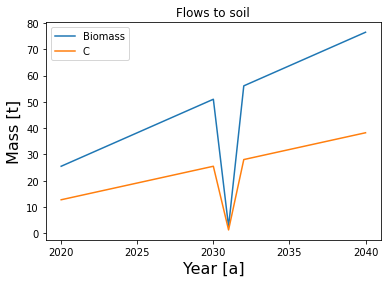

In [78]:
fig, ax = plt.subplots()

ax.plot(Dyn_MFA_System.IndexTable['Classification']['Time'].Items, 
        Dyn_MFA_System.FlowDict['F_4_9'].Values[:,0] + Dyn_MFA_System.FlowDict['F_5_9'].Values[:,0]) # [:,0] for all years and element Biomass
ax.plot(Dyn_MFA_System.IndexTable['Classification']['Time'].Items, 
        Dyn_MFA_System.FlowDict['F_4_9'].Values[:,1] + Dyn_MFA_System.FlowDict['F_5_9'].Values[:,1]) # [:,1] for all years and element Carbon

ax.set_ylabel('Mass [t]',fontsize = 16)
ax.set_xlabel('Year [a]',fontsize = 16)
ax.set_title("Flows to soil")
ax.legend(ModelClassification['Element'].Items)
ax.xaxis.set_major_locator(MultipleLocator(5))


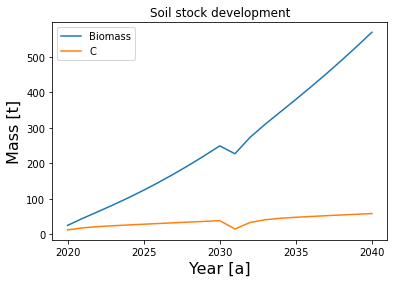

In [80]:
fig, ax = plt.subplots()

ax.plot(Dyn_MFA_System.IndexTable['Classification']['Time'].Items, 
        Dyn_MFA_System.StockDict['S_9'].Values[:,0]) # [:,0] for all years and element Biomass
ax.plot(Dyn_MFA_System.IndexTable['Classification']['Time'].Items, 
        Dyn_MFA_System.StockDict['S_9'].Values[:,1]) # [:,1] for all years and element Carbon
ax.set_ylabel('Mass [t]',fontsize = 16)
ax.set_xlabel('Year [a]',fontsize = 16)
ax.set_title("Soil stock development")
ax.legend(ModelClassification['Element'].Items)
ax.xaxis.set_major_locator(MultipleLocator(5))


### 4.2 Interactive Sankey diagram

In [81]:
# Here, the data of the ODYM MFA system is extracted and put into an applicable form for the interactive Sankey diagram 


# Loop through all flows and extract their starting process
flows_P_Start = []
for flow in Dyn_MFA_System.FlowDict:
    flows_P_Start.append(Dyn_MFA_System.FlowDict[flow].P_Start)

# Loop through all flows and extract their end process
flows_P_End = []
for flow in Dyn_MFA_System.FlowDict:
    flows_P_End.append(Dyn_MFA_System.FlowDict[flow].P_End)

    
# Loop through all flows and extract their values
flows_Values = []
for flow in Dyn_MFA_System.FlowDict:
    flows_Values.append(Dyn_MFA_System.FlowDict[flow].Values)


# Choose colors for flows
colors_flows = []
colors_flows.extend(["darkseagreen" for i in range(3)])
colors_flows.extend(["skyblue" for i in range(11)])
colors_flows.extend(["salmon" for i in range(1)])

# Choose colors for processes
colors_processes = ["darkseagreen", "darkseagreen", "darkseagreen", "skyblue", "skyblue", "skyblue", 
               "skyblue", "skyblue", "skyblue", "salmon", "lavender", "lavender"
                  ]  

# Get values for Biomass
flows_Values_loop_Biomass = []
for i in range(len(MyYears)):
    loop_list = []
    for b in range(len(Dyn_MFA_System.FlowDict)):
        loop_list.append(flows_Values[b][:][i][0])
    flows_Values_loop_Biomass.append(loop_list)

# Get values for Carbon
flows_Values_loop_Carbon = []
for i in range(len(MyYears)):
    loop_list = []
    for b in range(len(Dyn_MFA_System.FlowDict)):
        loop_list.append(flows_Values[b][:][i][1]) 
    flows_Values_loop_Carbon.append(loop_list)

# Get names of processes
labels = []
for i in range(len(Dyn_MFA_System.ProcessList)):
    labels.append(Dyn_MFA_System.ProcessList[i].Name)
    


In [83]:
# Define formular that uses the data of the previous cell to create an interactive Sankey diagram
def sankey_diagram_results(flows_Values_loop, element):
    
    fig = go.FigureWidget()
    fig.add_sankey(node = dict(
          pad = 15,
          thickness = 20,
          line = dict(color = "black", width = 0.5),
          label = labels,
          color = colors_processes
        ),
        link = dict(
          source = flows_P_Start, 
          target = flows_P_End,
          value = flows_Values_loop[0],
            color = colors_flows,
      ))

    fig.layout.title = f"""System Sankey diagram {element} (years {MyYears[0]}-{MyYears[-1]}) [t]"""
    display(fig)
  
    # this functions updates thi Sankey diagram to make it interactive and introduces the slider feature
    def up(i=0):
        fig.data[0].link.value = (flows_Values_loop[i-(MyYears[0])])
        fig.layout.title = f"""System Sankey diagram {element} (year {i}) [t]"""
    interact(up, i = (MyYears[0], MyYears[-1], 1));

In [84]:
# Apply formula for Biomass
# If diagram does not show, try enableling the widgetsnbextension 
# by running: jupyter nbextension enable --py --sys-prefix widgetsnbextension
sankey_diagram_results(flows_Values_loop_Biomass, ModelClassification['Element'].Items[0])

FigureWidget({
    'data': [{'link': {'color': [darkseagreen, darkseagreen, darkseagreen,
                    …

interactive(children=(IntSlider(value=2020, description='i', max=2040, min=2020), Output()), _dom_classes=('wi…

In [86]:
# Apply formula for Carbon
sankey_diagram_results(flows_Values_loop_Carbon, ModelClassification['Element'].Items[1])

FigureWidget({
    'data': [{'link': {'color': [darkseagreen, darkseagreen, darkseagreen,
                    …

interactive(children=(IntSlider(value=2020, description='i', max=2040, min=2020), Output()), _dom_classes=('wi…

### 4.3 Monte-Carlo-Simulation results

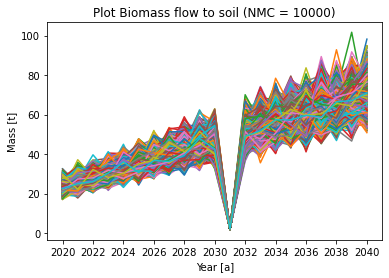

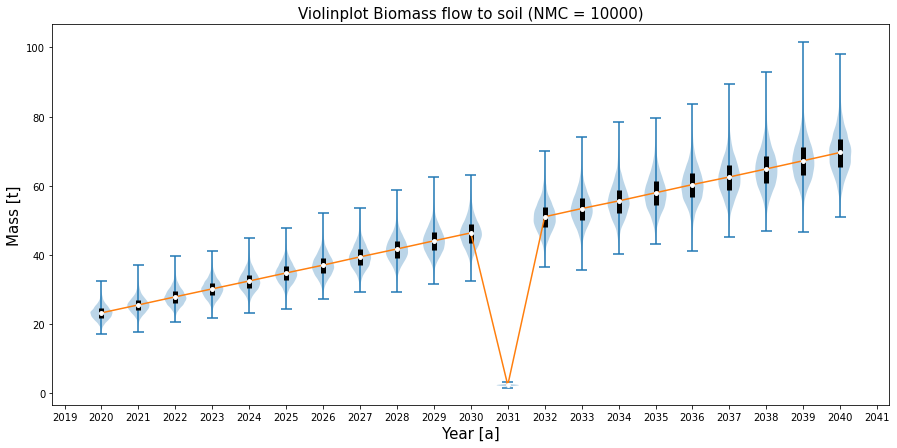

In [87]:
# Biomass flow to soil

fig, ax = plt.subplots()

#Simple plotting
for key in range(0, NMC):
        ax.plot(Dyn_MFA_System.IndexTable['Classification']['Time'].Items, 
            MC_BioInflowArray[key,:,0])

ax.set_title(f"Plot Biomass flow to soil (NMC = {NMC})")
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.set_ylabel('Mass [t]')
ax.set_xlabel('Year [a]')




#Violing plotting showing data ranges, upper and lower quartil, mean values and probability density function
plt.figure(figsize = (15,7))
plt.violinplot(MC_BioInflowArray[:,:,0],positions = Dyn_MFA_System.IndexTable['Classification']['Time'].Items,
                widths=0.6)


quartile1, quartile3 = np.percentile(MC_BioInflowArray[:,:,0], [25, 75], axis=0)

plt.vlines(Dyn_MFA_System.IndexTable['Classification']['Time'].Items, quartile1, quartile3, color='k', linestyle='-', lw=5)
plt.scatter(Dyn_MFA_System.IndexTable['Classification']['Time'].Items, np.mean(MC_BioInflowArray[:,:,0], axis = 0), marker='o', color='white', s=15, zorder=3)
plt.plot(Dyn_MFA_System.IndexTable['Classification']['Time'].Items, np.mean(MC_BioInflowArray[:,:,0], axis = 0))

plt.title(f"Violinplot Biomass flow to soil (NMC = {NMC})", fontsize = 15)
plt.ylabel('Mass [t]', fontsize = 15)
plt.xlabel('Year [a]', fontsize = 15);
plt.xticks(np.arange(min(Dyn_MFA_System.IndexTable['Classification']['Time'].Items)-1, max(Dyn_MFA_System.IndexTable['Classification']['Time'].Items)+2, 1.0))



plt.show()

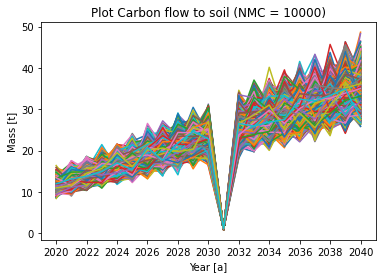

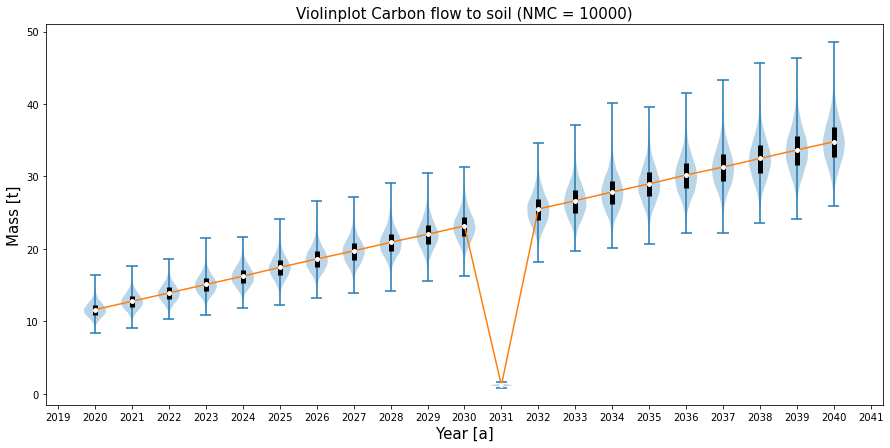

In [88]:
# Carbon flow to soil
fig, ax = plt.subplots()

#Simple plotting
for key in range(0, NMC):
        ax.plot(Dyn_MFA_System.IndexTable['Classification']['Time'].Items, 
            MC_BioInflowArray[key,:,1])

ax.set_title(f"Plot Carbon flow to soil (NMC = {NMC})")
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.set_ylabel('Mass [t]')
ax.set_xlabel('Year [a]')




#Violing plotting showing data ranges, upper and lower quartil, mean values and probability density function
plt.figure(figsize = (15,7))
plt.violinplot(MC_BioInflowArray[:,:,1],positions = Dyn_MFA_System.IndexTable['Classification']['Time'].Items,
                widths=0.6)


quartile1, quartile3 = np.percentile(MC_BioInflowArray[:,:,1], [25, 75], axis=0)

plt.vlines(Dyn_MFA_System.IndexTable['Classification']['Time'].Items, quartile1, quartile3, color='k', linestyle='-', lw=5)
plt.scatter(Dyn_MFA_System.IndexTable['Classification']['Time'].Items, np.mean(MC_BioInflowArray[:,:,1], axis = 0), marker='o', color='white', s=15, zorder=3)
plt.plot(Dyn_MFA_System.IndexTable['Classification']['Time'].Items, np.mean(MC_BioInflowArray[:,:,1], axis = 0))

plt.title(f"Violinplot Carbon flow to soil (NMC = {NMC})", fontsize = 15)
plt.ylabel('Mass [t]', fontsize = 15)
plt.xlabel('Year [a]', fontsize = 15);
plt.xticks(np.arange(min(Dyn_MFA_System.IndexTable['Classification']['Time'].Items)-1, max(Dyn_MFA_System.IndexTable['Classification']['Time'].Items)+2, 1.0))



plt.show()

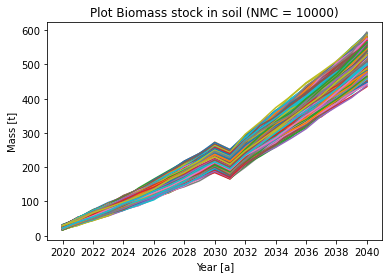

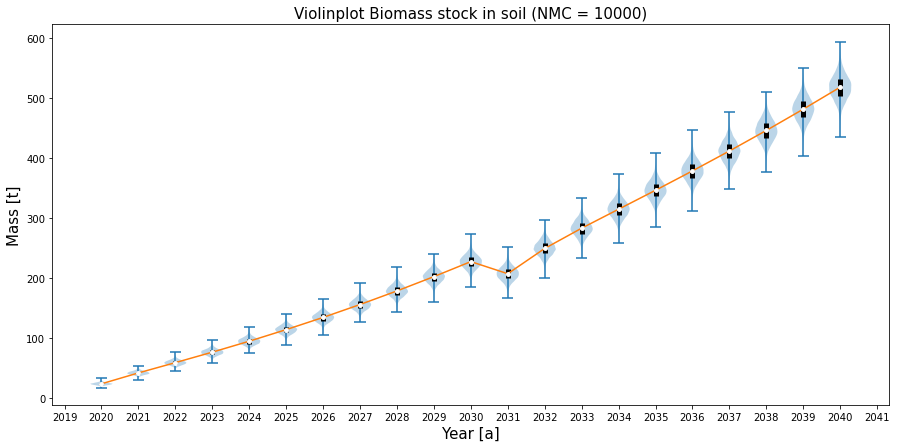

In [89]:
# Biomass stock in soil
fig, ax = plt.subplots()

#Simple plotting
for key in range(0, NMC):
        ax.plot(Dyn_MFA_System.IndexTable['Classification']['Time'].Items, 
            MC_StockDict['S_9'][key,:,0])

ax.set_title(f"Plot Biomass stock in soil (NMC = {NMC})")
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.set_ylabel('Mass [t]')
ax.set_xlabel('Year [a]')




#Violing plotting showing data ranges, upper and lower quartil, mean values and probability density function
plt.figure(figsize = (15,7))
plt.violinplot(MC_StockDict['S_9'][:,:,0],positions = Dyn_MFA_System.IndexTable['Classification']['Time'].Items,
                widths=0.6)


quartile1, quartile3 = np.percentile(MC_StockDict['S_9'][:,:,0], [25, 75], axis=0)

plt.vlines(Dyn_MFA_System.IndexTable['Classification']['Time'].Items, quartile1, quartile3, color='k', linestyle='-', lw=5)
plt.scatter(Dyn_MFA_System.IndexTable['Classification']['Time'].Items, np.mean(MC_StockDict['S_9'][:,:,0], axis = 0), marker='o', color='white', s=15, zorder=3)
plt.plot(Dyn_MFA_System.IndexTable['Classification']['Time'].Items, np.mean(MC_StockDict['S_9'][:,:,0], axis = 0))

plt.title(f"Violinplot Biomass stock in soil (NMC = {NMC})", fontsize = 15)
plt.ylabel('Mass [t]', fontsize = 15)
plt.xlabel('Year [a]', fontsize = 15);
plt.xticks(np.arange(min(Dyn_MFA_System.IndexTable['Classification']['Time'].Items)-1, max(Dyn_MFA_System.IndexTable['Classification']['Time'].Items)+2, 1.0))



plt.show()

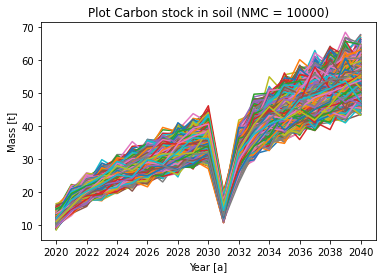

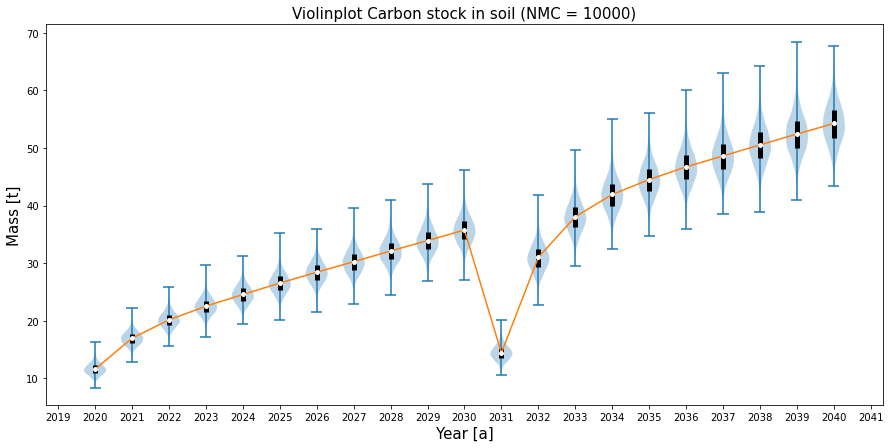

In [90]:
# Carbon stock in soil
fig, ax = plt.subplots()

#Simple plotting
for key in range(0, NMC):
        ax.plot(Dyn_MFA_System.IndexTable['Classification']['Time'].Items, 
            MC_StockDict['S_9'][key,:,1])

ax.set_title(f"Plot Carbon stock in soil (NMC = {NMC})")
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.set_ylabel('Mass [t]')
ax.set_xlabel('Year [a]')




#Violing plotting showing data ranges, upper and lower quartil, mean values and probability density function
plt.figure(figsize = (15,7))
plt.violinplot(MC_StockDict['S_9'][:,:,1],positions = Dyn_MFA_System.IndexTable['Classification']['Time'].Items,
                widths=0.6)


quartile1, quartile3 = np.percentile(MC_StockDict['S_9'][:,:,1], [25, 75], axis=0)

plt.vlines(Dyn_MFA_System.IndexTable['Classification']['Time'].Items, quartile1, quartile3, color='k', linestyle='-', lw=5)
plt.scatter(Dyn_MFA_System.IndexTable['Classification']['Time'].Items, np.mean(MC_StockDict['S_9'][:,:,1], axis = 0), marker='o', color='white', s=15, zorder=3)
plt.plot(Dyn_MFA_System.IndexTable['Classification']['Time'].Items, np.mean(MC_StockDict['S_9'][:,:,1], axis = 0))

plt.title(f"Violinplot Carbon stock in soil (NMC = {NMC})", fontsize = 15)
plt.ylabel('Mass [t]', fontsize = 15)
plt.xlabel('Year [a]', fontsize = 15);
plt.xticks(np.arange(min(Dyn_MFA_System.IndexTable['Classification']['Time'].Items)-1, max(Dyn_MFA_System.IndexTable['Classification']['Time'].Items)+2, 1.0))



plt.show()

### 4.4 Export of results to Excel

In [91]:
# Export values of all flows and stocks to Excel

flow_labels_new = []
for flow in Dyn_MFA_System.FlowDict:
    flow_labels_new.append(Dyn_MFA_System.FlowDict[flow].Name)
flow_labels_new

stock_labels_new = []
for stock in Dyn_MFA_System.StockDict:
    stock_labels_new.append(Dyn_MFA_System.StockDict[stock].Name)
stock_labels_new

flows_Values_new = []
for flow in Dyn_MFA_System.FlowDict:
    Dyn_MFA_System.FlowDict[flow].Values[:,0].shape = (21)
    flows_Values_new.append(Dyn_MFA_System.FlowDict[flow].Values[:,0])

df_flows = pd.DataFrame(flows_Values_new).T
df_flows.columns = flow_labels_new
df_flows['Years'] = MyYears
df_flows.set_index('Years', inplace=True, drop=True)

stock_Values_new = []
for stock in Dyn_MFA_System.StockDict:
    Dyn_MFA_System.StockDict[stock].Values[:,0].shape = (21)
    stock_Values_new.append(Dyn_MFA_System.StockDict[stock].Values[:,0])

df_stock = pd.DataFrame(stock_Values_new).T
df_stock.columns = stock_labels_new
df_stock['Years'] = MyYears
df_stock.set_index('Years', inplace=True, drop=True)


writer = pd.ExcelWriter('Case_study_results.xlsx', engine='xlsxwriter')


df_flows.to_excel(writer, sheet_name='FlowDict_Biomass')
df_stock.to_excel(writer, sheet_name='StockDict_Biomass')




flows_Values_new = []
for flow in Dyn_MFA_System.FlowDict:
    Dyn_MFA_System.FlowDict[flow].Values[:,1].shape = (21)
    flows_Values_new.append(Dyn_MFA_System.FlowDict[flow].Values[:,1])

df_flows = pd.DataFrame(flows_Values_new).T
df_flows.columns = flow_labels_new
df_flows['Years'] = MyYears
df_flows.set_index('Years', inplace=True, drop=True)

stock_Values_new = []
for stock in Dyn_MFA_System.StockDict:
    Dyn_MFA_System.StockDict[stock].Values[:,1].shape = (21)
    stock_Values_new.append(Dyn_MFA_System.StockDict[stock].Values[:,1])

df_stock = pd.DataFrame(stock_Values_new).T
df_stock.columns = stock_labels_new
df_stock['Years'] = MyYears
df_stock.set_index('Years', inplace=True, drop=True)

df_flows.to_excel(writer, sheet_name='FlowDict_Carbon')
df_stock.to_excel(writer, sheet_name='StockDict_Carbon')


writer.save()


In [92]:
# Export mean values of MCS along with absolute Standard Deviation values of all flows and stocks to Excel

flow_labels_new = []
for flow in MC_FlowDict:
    flow_labels_new.append(flow)
    flow_labels_new.append(f"{flow}_absSTD")

stock_labels_new = []
for stock in MC_StockDict:
    stock_labels_new.append(stock)
    stock_labels_new.append(f"{stock}_absSTD")
    
flows_Values_new = []
for flow in MC_FlowDict:
    flows_Values_new.append(np.mean(MC_FlowDict[flow], axis = 0))
    flows_Values_new.append(MC_FlowDict_absSTD[f"{flow}_absSTD"])
    

df_flows_Biomass = pd.DataFrame([i[:,0] for i in flows_Values_new]).T
df_flows_Biomass.columns = flow_labels_new
df_flows_Biomass['Years'] = MyYears
df_flows_Biomass.set_index('Years', inplace=True, drop=True)

df_flows_Carbon = pd.DataFrame([i[:,1] for i in flows_Values_new]).T
df_flows_Carbon.columns = flow_labels_new
df_flows_Carbon['Years'] = MyYears
df_flows_Carbon.set_index('Years', inplace=True, drop=True)


stock_Values_new = []
for stock in MC_StockDict:
    stock_Values_new.append(np.mean(MC_StockDict[stock], axis = 0))
    stock_Values_new.append(MC_StockDict_absSTD[f"{stock}_absSTD"])
    
df_stock_Biomass = pd.DataFrame([i[:,0] for i in stock_Values_new]).T
df_stock_Biomass.columns = stock_labels_new
df_stock_Biomass['Years'] = MyYears
df_stock_Biomass.set_index('Years', inplace=True, drop=True)

df_stock_Carbon = pd.DataFrame([i[:,1] for i in stock_Values_new]).T
df_stock_Carbon.columns = stock_labels_new
df_stock_Carbon['Years'] = MyYears
df_stock_Carbon.set_index('Years', inplace=True, drop=True)


writer = pd.ExcelWriter('Case_study_results_MC_mean.xlsx', engine='xlsxwriter')

df_flows_Biomass.to_excel(writer, sheet_name='MC_FlowDict_Biomass')
df_stock_Biomass.to_excel(writer, sheet_name='MC_StockDict_Biomass')


df_flows_Carbon.to_excel(writer, sheet_name='MC_FlowDict_Carbon')
df_stock_Carbon.to_excel(writer, sheet_name='MC_StockDict_Carbon')


writer.save()